# DASi to Aquarium

**Inputs**

* `design.out.json`
* `design.out.resolved.json` <- design output with resolveda aquarium sequences
* `SelectedInventory.csv`

**Outputs**

In [1]:
import pandas as pd
import json

In [2]:
# login to Benchling & Aquarium
from aqbt.tools import config_to_sessions
from aqbt.tools import parse_config
import toml

def config(config_path):
    with open(config_path, "r") as f:
        return parse_config(toml.load(f))


def sessions(config):
    return config_to_sessions(config)


sessions = sessions(config('config.toml'))

benchling = sessions['default']['benchling']
registry = sessions['default']['registry']
session = sessions['default']['aquarium']
sessions

{'default': {'aquarium': <AqSession(name=None, AqHTTP=<AqHTTP(user='vrana', url='http://52.27.43.242')>), parent=94071587996512)>,
  'benchling': <benchlingapi.session.Session at 0x7f8953d3d6d0>,
  'registry': <aqbt.aquarium.registry.LabDNARegistry at 0x7f8953d5edc0>}}

##### Load `SelectedInventory.csv`

In [3]:
inv_df = pd.read_csv("SelectedInventory.csv", index_col=0)
inv_df.head()

,entity_registry_id,is_available,is_circular,record,record_uuid,sample,sample_id,sample_type,sequence_hash
286,NaN,True,False,ID: 1010__vf2\nName: vf2\nDescription: <unknow...,b227364f-4708-4976-a960-34e8fb019670,<Sample id=1010 name=vf2 sample_type={'rid': 1...,1010,Primer,ed119701ab23e88921ecee8ef629a110265c65ae
287,NaN,True,False,ID: 1014__c-myc-F\nName: c-myc-f\nDescription:...,e27abdee-dda1-4ede-8975-2c2f43d631f8,<Sample id=1014 name=c-myc-F sample_type={'rid...,1014,Primer,d48a98059541b2acf77b13bf59645a5f3cdc5ca5
288,NaN,True,False,ID: 1015__trp_F\nName: trp_f\nDescription: <un...,365e36ea-ec97-4e5f-88a5-3a21ae2e8077,<Sample id=1015 name=trp_F sample_type={'rid':...,1015,Primer,78dd1501c912b9f080e72e7854fa6385e01d0757
289,NaN,True,False,ID: 1016__cen6_F\nName: cen6_f\nDescription: <...,df022340-6045-4368-9e20-4daa01642695,<Sample id=1016 name=cen6_F sample_type={'rid'...,1016,Primer,323188271e4745f3d111680404159569e643890b
290,NaN,True,False,ID: 1039__PP2-Gal1m-f\nName: pp2-gal1m-f\nDesc...,fb3ff6dc-edf5-40dd-8171-83f3ac2d1d3b,<Sample id=1039 name=PP2-Gal1m-f sample_type={...,1039,Primer,bb336cb902b7593df17ca1ee42113f3a54b75912


##### Load `design.out.json`

In [4]:
with open('design.out.json', 'r') as f:
    design_out = json.load(f)
    
print(design_out.keys())
design_out['metadata']

dict_keys(['metadata', 'designs', 'molecules', 'reactions'])


{'program': 'dasi', 'version': '0.1.0', 'execution_trace': {}}

### Convert Output to Aquarium Input Spreadsheets

In [12]:
from uuid import uuid4
import hashlib
from tqdm import tqdm_notebook as tqdm
import json

registry = sessions['default']['registry']
session = registry.session

PREFIX = "PlantTF_2020_Campaign_"
primer_type = session.SampleType.find_by_name('Primer')
fragment_type = session.SampleType.find_by_name('Fragment')
plasmid_type = session.SampleType.find_by_name('Plasmid')
# recycler = SampleRecycler(session)


def seq_sha1(seq: str) -> str:
    """Convert sequence string into a hash"""
    return hashlib.sha1(seq.strip().upper().encode()).hexdigest()

def new_name(molecule):
    name = molecule['__name__']
    if name == "PRIMER":
        typename = 'Primer'
    elif 'PCR' in name:
        typename = 'Fragment'
    elif name in ['GAP', 'SHARED_SYNTHESIZED_FRAGMENT']:
        typename = 'Synthesized'
    else:
        raise ValueError
    
    seqhash = seq_sha1(molecule['sequence']['bases'])
    return '{}_{}_{}'.format(typename, PREFIX, seqhash[-8:])

def new_sample(sample_type, name, description, project, properties):
    new_sample = sample_type.new_sample(
        name=name,
        description=description,
        project=project,
        properties=properties
    )
#     sample = recycler.reuse(sample_type.id)
    sample = None
    if sample:
        for fv in sample.field_values:
            assert fv.value is None
            assert fv.child_sample_id is None
            assert fv.sample is None
        sample.name = new_sample.name
        sample.description = new_sample.description
        sample.update_properties(new_sample.properties)
        sample.needs_update = True
    else:
        sample = new_sample
    return sample

def _resolve_primer(m, inv_df):
    row = inv_df[inv_df['sequence_hash'] == seq_sha1(m['sequence']['bases'])]
    if len(row):
        sample_id = int(row['sample_id'].values[0])
        
        assert sample_id
        sample = session.Sample.find(sample_id)
        assert sample
        return sample
    else:
        return new_sample(sample_type=primer_type,
            name=new_name(m),
            description='dasi designed',
            project='SD2',
            properties={
                'Anneal Sequence': m['__meta__']['SEQUENCE'],
                'Overhang Sequence': m['__meta__']['OVERHANG'],
                'T Anneal': round(m['__meta__']['TM'] - 2, 2)
            }
        )
    
def _resolve_fragment(m, results, df):
    reactions = m['used_as_output_to_reactions']
    assert len(reactions) == 1
    inputs = results['reactions'][reactions[0]]['inputs']
    input_molecules = [results['molecules'][i] for i in inputs]
    primers = [m for m in input_molecules if m['__name__'] == 'PRIMER']
    templates = [m for m in input_molecules if m['__name__'] == 'TEMPLATE']
    assert len(primers) == 2
    assert len(templates) == 1
    
    fwd = _resolve_primer(primers[0], df)
    rev = _resolve_primer(primers[1],df)
    
    return new_sample(
        sample_type=fragment_type,
        name=new_name(m),
        description='dasi designed',
        project='SD2',
        properties={
            'Forward Primer': fwd,
            'Reverse Primer': rev,
            'Template': _resolve_template(templates[0]),
            'Length': len(m['sequence']['bases']),
            'Sequence': '',
        }
    )


    
def _resolve_template(m):
    lims_id = m['sequence']['LIMS_ID']
    assert lims_id
    sample = session.Sample.find(lims_id)
    assert sample
    return sample

def _resolve_gblock(m):
    return new_sample(
        sample_type=fragment_type,
        name=new_name(m),
        description='dasi designed',
        project='SD2',
        properties={
            'Sequence': m['sequence']['bases'],
            'Length': len(m['sequence']['bases'])
        }
    )

def _resolve_plasmid(m):
    return new_sample(
        sample_type=plasmid_type,
        name=m['sequence']['name'],
        description='dasi designed',
        project='SD2',
        properties={
            'Sequence': m['sequence']['bases'],
            'Length': len(m['sequence']['bases']),
            'Bacterial Marker': 'Amp'
        }
    )
    
def _resolve_molecule(m, results, df):
    if m['__name__'] in ['GAP', 'SHARED_SYNTHESIZED_FRAGMENT']:
        return _resolve_gblock(m)
    elif m['__name__'] in ['PCR_PRODUCT', 'PCR_PRODUCT_WITH_LEFT_PRIMER',
                          'PCR_PRODUCT_WITH_RIGHT_PRIMER', 'PCR_PRODUCT_WITH_PRIMERS']:
        return _resolve_fragment(m, results, df)
    elif m['__name__'] == 'TEMPLATE':
        return _resolve_template(m)
    elif m['__name__'] == 'PRE-MADE DNA FRAGMENT':
        return _resolve_template(m)
    elif m['__name__'] == 'PRIMER':
        return _resolve_primer(m, df)
    elif m['__name__'] == 'PLASMID':
        return _resolve_plasmid(m)
    else:
        raise ValueError(m['__name__'] + " not recognized")

def resolve_molecules(results, df):
    molecules = results['molecules']
    for m in molecules:
        m['__sample__'] = None

    for m in molecules:
        resolved = _resolve_molecule(m, results, df)
        if resolved:
            m['__sample__'] = resolved
    return molecules

In [ ]:
##################
# Submit
##################

from pydent import Planner
from pydent import save_inventory

resolve_molecules(design_out, inv_df)
design_id = seq_sha1(json.dumps(design_out['designs']))

##################
# Save inventory
##################
all_samples = [m['__sample__'] for m in design_out['molecules']]
new_samples = [m['__sample__'] for m in design_out['molecules'] if not m['__sample__'].id]

##################
# Update samples
##################
to_update = [m['__sample__'] for m in design_out['molecules'] if hasattr(m['__sample__'], 'needs_update')]

print(len(new_samples))
print(len(to_update))

102
0


### Lint Samples

### Create Spreadsheets

In [43]:
from typing import List
from pydent.models import Sample
import dictdiffer

def samples_to_dfs(session, samples: List[Sample], project):
    sample_by_st = {}
    with session.with_cache(timeout=60) as sess:
        sess.browser.get(samples, {
            'sample_type': {
                'field_types': 'allowable_field_types'
            },
            'field_values': {
                'sample': 'sample_type',
                'field_type': [],
                'allowable_field_type': []
            }
        })
    for s in samples:
        sample_by_st.setdefault(s.sample_type.name, {
            'samples': [],
            'sample_type': s.sample_type
        })
        sample_by_st[s.sample_type.name]['samples'].append(s)
        
    data = {}
    for k, v in sample_by_st.items():
        data[k] = _samples_to_df(v['samples'], v['sample_type'], project)
    return data

def _resolve_field_value(fv):
    if fv.ftype == 'sample':
        if fv.sample:
            return fv.sample.name
        elif fv.child_sample_id:
            return fv.child_sample_id
    else:
        return fv.value
    
def _samples_to_df(samples, sample_type, project):
    prop_columns = []
    for ft in sample_type.field_types:
        if ft.array:
            prop_columns.append([ft.name])
        else:
            prop_columns.append(ft.name)
    columns = [sample_type.name, 'Description', 'Project'] + prop_columns
    
    rows = []
    for s in samples:
        row = {
            sample_type.name: s.name,
            'Description': s.description,
            'Project': project
        }
        for prop in prop_columns:
            if isinstance(prop, list):
                pass
            else:
                v = s.properties[prop]
                if isinstance(v, Sample):
                    v = v.name
                row[prop] = v
        rows.append(row)
    
    return pd.DataFrame(rows)


def props(s):
    if not s.field_values:
        return {}
    data = s.properties
    for k, v in data.items():
        if isinstance(v, Sample):
            data[k] = v.name
        elif isinstance(v, list):
            new_v = []
            for _v in v:
                if isinstance(v, Sample):
                    new_v.append('Sample_{}'.format(v.name))
            new_v.sort()
            data[k] = new_v
    return data
            
    
def compare_samples(s1, s2):
    d1 = props(s1)
    d2 = props(s2)
    return list(dictdiffer.diff(d1, d2))

    
assert compare_samples(new_samples[0], new_samples[1])
assert not compare_samples(new_samples[0], new_samples[0])
        
def partition_new_samples(session, samples: List[Sample]):
    to_save = []
    to_update = []
    
    with session(using_cache=False) as sess:
        sample_names = [s.name for s in samples]
        existing_by_name = {s.name: s for s in sess.Sample.where({'name': sample_names})}
        
        for sample in samples:
            if sample.name in existing_by_name:
                existing = existing_by_name[sample.name]
                
                if compare_samples(sample, existing):
                    print("Need to update {}".format(sample.name))
                    to_update.append((sample, existing))
                elif sample.id != existing.id:
                    print("Updating id {}".format(sample.name))
                    sample.id = existing.id
                else:
                    print('pass')
            else:
                print("Need to save {}".format(sample.name))
                to_save.append(sample)
    
    print("{} require updates".format(len(to_update)))
    print("{} require saving".format(len(to_save)))
    return {
        'save': to_save,
        'update': to_update
    }
    
partition = partition_new_samples(session, new_samples)

pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
Need to update Fragment_PlantTF_2020_Campaign__8a44e29a
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
pass
Need to update Fragment_PlantTF_2020_Campaign__9030f226
pass
Need to update Fragment_PlantTF_2020_Campaign__56bdab7c
pass
Need to update Fragment_PlantTF_2020_Campaign__2a7cbca2
pass
pass
Need to update Fragment_PlantTF_2020_Campaign__d0b310a2
Need to update Fragment_PlantTF_2020_Campaign__03bd62cb
pass
pass
pass
Need to update Fragment_PlantTF_2020_Campaign__cb0e46b1
pass
Need to update Fragment_PlantTF_2020_Campaign__23d83be1
pass
pass
Need to update Fragment_PlantTF_2020_Campaign__706b91fe
Need to update Fragment_PlantTF_2020_Campaign__5c9538dc
pass
pass
Need to update Fragment_PlantTF_2020_Campaign__ede7d5a7
pass
Need to update Fragment_PlantTF_2020_Campaign__3d2a2a55
pass
pass
Need to update Fragment_PlantTF_2020_Campaign__1be71d34
pass
Need to update Fragment_PlantTF_2020_Campaign__9f01e52f
pass
pass
pass
pass
pass
p

In [ ]:
from pydent.inventory_updater import models_to_graph
import networkx as nx

with session(using_cache=False) as sess:
    sample_names = [s.name for s in new_samples]
    existing_by_name = {s.name: s for s in sess.Sample.where({'name': sample_names})}

g = models_to_graph(session, new_samples)

# resolve by name
samples_by_name = {}
for n, ndata in g.nodes(data=True):
    model = ndata['model']
    if model.name not in samples_by_name:
        samples_by_name[model.name] = model
    else:
        assert not compare_samples(model, samples_by_name[model.name])
        ndata['model'] = samples_by_name[model.name]
        
        
samples = []
for n, ndata in g.nodes(data=True):
    model = ndata['model']
    for fv in model.field_values:
        if fv.sample and fv.sample.name in samples_by_name:
            fv_sample = samples_by_name[fv.sample.name]
            fv.sample = fv_sample
            fv.child_sample_id = fv_sample.id
    samples.append(model)
            
from collections import OrderedDict
to_save = OrderedDict()
to_update = OrderedDict()


with session(using_cache=False) as sess:
    sample_names = [s.name for s in samples]
    existing_models = sess.Sample.where({'name': sample_names})
    existing_models_by_name = {s.name: s for s in existing_models}
    

with session.with_cache() as sess:
    sess.browser.get(existing_models, {
        'sample_type': {
            'field_types': 'allowable_field_types'
        },
        'field_values': {
            'sample': 'sample_type',
            'field_type': 'allowable_field_types',
            'allowable_field_type': []
        }
    })
print("OKJLJLJ")
to_save = []
to_update = []
for n in nx.topological_sort(g):
    model = g.nodes[n]['model']
    if model.name in to_save or model.name in to_update:
        pass
    existing = existing_models_by_name.get(model.name, None)
    if existing:
        diff = compare_samples(model, existing)
        if diff:
            to_update.append((model, existing))
        elif model.id is None:
            model.id = existing.id
    else:
        to_save.append(model)

# save first!

# then update!
def update_sample(session, new_model, old_model):
    for fv in new_model.field_values:
        if fv.sample and not fv.sample.id:
            raise Exception("Sample should have been saved or updated")
    existing.update_properties(new_model.properties)
    existing.update()
    
    # check from server
    with session(using_cache=False) as sess:
        s = sess.Sample.find_by_name(new_model.name)
    assert not diff(s, new_model)


def diff_from_server(session, sample):
    s2 = session().Sample.find_by_name(sample.name)
    return compare_samples(sample, s2)
    
def push_sample_to_server(session, new_model, primary_key: str):
    print(new_model.name)
    assert isinstance(new_model, Sample)
    pkchoies = ['id', 'name']
    if primary_key not in pkchoies:
        raise Exception('Primary key must be in {}'.format(pkchoies))
    if getattr(new_model, primary_key) is None:
        raise Exception("Cannot update. Model has no {}.".format(primary_key))
    else:
        with session(using_cache=False) as sess:
            existing = sess.Sample.where({primary_key: getattr(new_model, primary_key)})
            if not existing:
                raise Exception("Model does not exist on server.")
            else:
                existing = existing[0]
            print(existing)
            diff = compare_samples(existing, new_model)
            if not diff:
                if new_model.id is None:
                    new_model.id = existing.id
                print("Update not necessary.")
            else:
                existing.update_properties(new_model.properties)
                existing.update()
                new_model.update_properties(existing.properties)
                
                from_server = sess.Sample.find(existing.id)
                diff = compare_samples(from_server, new_model)
                if diff:
                    raise Exception("Update was not successful.\n{}".format(diff))
                new_model.reload(existing.dump())
                return new_model
    
for s1, s2 in to_update:
    s1.name = s2.name
    push_sample_to_server(session, s1, primary_key='name')
# props(s1) 
# diff_from_server(session, s1)
# def update_sample(session, new_model, old_model):
#     print(new_model.name)
    
#     for fv in new_model.field_values:
#         if fv.sample and not fv.sample.id:
#             raise Exception("Sample should have been saved or updated")
#     old_model.update_properties(new_model.properties)
#     old_model.update()
    
#     # check from server
#     with session(using_cache=False) as sess:
#         s = sess.Sample.find_by_name(new_model.name)
#     diff = compare_samples(s, new_model)
#     assert not diff
    
# for s in to_update:
#     update_sample(session, s[0], s[1])


# print(to_update)
#         samples_by_name[ndata['model'].name] = ndata['model']
        
# for n, ndata in g.nodes(data=True):
#     ndata['model'] = samples_by_name[ndata['model']]


# # pull from server
# for n in nx.topological_sort(g):
#     model = graph.nodes[n]["model"]
#     if not model.id:
#         if model.name in existing_by_name:
#             # if exists and there is a difference
#             existing = existing_by_name[model.name]
#             diff = compare_samples(existing, model)
#             if diff:
#                 for fv in model.field_values:
#                     if fv.sample and not fv.sample.id:
#                         raise Exception("Sample should have been saved or updated")
#                 existing.update_properties(model.properties)
#                 existing.update()
        

OKJLJLJ


In [20]:
to_update

[[('change',
   'Forward Primer',
   ('Primer_PlantTF_2020_Campaign__b62e091d', None)),
  ('change',
   'Reverse Primer',
   ('Primer_PlantTF_2020_Campaign__d4837379', None))],
 [('change',
   'Forward Primer',
   ('Primer_PlantTF_2020_Campaign__e2481e72', None)),
  ('change',
   'Reverse Primer',
   ('Primer_PlantTF_2020_Campaign__d4837379', None))],
 [('change',
   'Forward Primer',
   ('Primer_PlantTF_2020_Campaign__d0965b5b', None)),
  ('change',
   'Reverse Primer',
   ('Primer_PlantTF_2020_Campaign__3a3d64ce', None))],
 [('change',
   'Forward Primer',
   ('Primer_PlantTF_2020_Campaign__50286755', None))],
 [('change',
   'Forward Primer',
   ('Primer_PlantTF_2020_Campaign__d43d079d', None)),
  ('change',
   'Reverse Primer',
   ('Primer_PlantTF_2020_Campaign__f6a4b370', None))],
 [('change',
   'Forward Primer',
   ('Primer_PlantTF_2020_Campaign__eaa75104', None))],
 [('change',
   'Forward Primer',
   ('Primer_PlantTF_2020_Campaign__d6c3d450', None)),
  ('change',
   'Reverse P

In [ ]:
upload_dfs = samples_to_dfs(session, needs_saving, project='YG-Four-inducible-plantTF-circuits')

for k, v in upload_dfs.items():
    v.to_csv("Upload_{}.csv".format(k), index=False)
    
print("*"*15 + ' To Upload: ' + "*"*15)
print("Step 1: Upload `{}`".format('Upload_Primer.csv'))
print("Step 2: Upload `{}`".format('Upload_Fragment.csv'))
print("Step 3: Upload `{}`".format('Upload_Plasmid.csv'))

## Resolve Design output and save

This dumps the Sample.json for each molecule in the design.out. Saves this file as `design.out.resolved.json`

In [48]:
def dump_sample(sample):
    props = {}
    for k, v in sample.properties.items():
        if isinstance(v, Sample):
            props[k] = {
                '__model__': 'Sample',
                'sample_type': {
                    'name': v.sample_type.name,
                    'id': v.sample_type_id
                },
                'name': v.name,
                'id': v.id
            }
        else:
            props[k] = v
    data = sample.dump()
    data['properties'] = props
    return data
    
from copy import deepcopy

copied_results = deepcopy(design_out)
for m in copied_results['molecules']:
    m['__sample__'] = dump_sample(m['__sample__'])
resolved_results = copied_results

with open('design.out.resolved.json', 'w') as f:
    json.dump(resolved_results, f)


## Visualize

<ipython-input-52-81567689251c>:220: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  isinstance(kwargs["node_color"], collections.Sequence) and


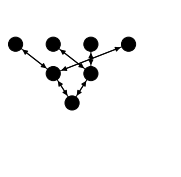

In [52]:
#@title Graph Plotter

import collections
import numpy as np
import networkx as nx
import pylab as plt
%matplotlib inline

def sorted_center(iterable, reverse=False, key=None, select=None):
    centered = []
    s = sorted(iterable, key=key, reverse=reverse)
    front = False
    for v in s:
        if not front:
            centered.append(v)
        else:
            centered.insert(0, v)
        front = not front
    if select:
        return [select(_x) for _x in centered]
    return centered

class GraphPlotter(object):
  
  def __init__(self, graph, ax=None, pos=None):
    if ax is None:
      ax = plt.figure(figsize=(3,3)).gca()
      ax.axis('off')
      ax.set_xlim(0, 1.0)
      ax.set_ylim(0, 1.0)
    
    self._ax = ax
    self._graph = graph
    if pos is None:
      self._pos = dict()
      self.spring_layout()
    else:
      self._pos = pos
      
  @property
  def _base_draw_kwargs(self):
    return dict(G=self._graph, ax=self._ax, pos=self._pos)
 
  def topological_sort(self):
    xlim = self._ax.get_xlim()
    ylim = self._ax.get_ylim()
    
    x = xlim[1] - xlim[0]
    y = ylim[1] - ylim[0]
    xspacer = x * 0.05
    yspacer = y * 0.05
    
    new_xlim = (xlim[0] + xspacer, xlim[1] - xspacer)
    new_ylim = (ylim[0] + yspacer, ylim[1] - yspacer)
    pos = self._topological_sort(self._graph, 
                                 xlim=new_xlim, 
                                 ylim=new_ylim)
    self._pos = pos

  @staticmethod
  def _roots_and_leaves(G, include_cycles=False):
    roots = [k for k, v in G.in_degree(G.nodes) if v == 0]
    leaves = [k for k, v in G.out_degree(G.nodes) if v == 0]
    
    if include_cycles:
      for c in nx.simple_cycles(G):
        outdegree = list(G.out_degree(c))
        outdegree.sort(key=lambda x: x[1])
        leaves.append(outdegree[0][0])

        indegree = list(G.out_degree(c))
        indegree.sort(key=lambda x: x[1])
        roots.append(indegree[0][0])
    return roots, leaves
  
  @classmethod
  def _get_roots(cls, G, include_cycles=False):
    return cls._roots_and_leaves(G, include_cycles=include_cycles)[0]

  @staticmethod
  def _get_leaves(G, include_cycles=False):
    return cls._roots_and_leaves(G, include_cycles=include_cycles)[1]

  @staticmethod
  def _get_subgraphs(graph):
    """Get independent subgraphs"""
    node_list = list(graph.nodes)
    subgraphs = []
    while len(node_list) > 0:
        node = node_list[-1]
        subgraph = nx.bfs_tree(to_undirected(graph), node)
        for n in subgraph.nodes:
            node_list.remove(n)
        subgraphs.append(graph.subgraph(subgraph.nodes))
    return subgraphs

  @classmethod
  def _topological_sort(cls, G, xlim=None, ylim=None):
    if xlim is None:
        xlim = [0.05, 0.95]
    if ylim is None:
        ylim = [0.05, 0.95]
    
    rts = cls._get_roots(G, include_cycles=True)
    max_depth = {}
    for root in rts:
        depths = nx.single_source_shortest_path_length(G, root)
        for n, d in depths.items():
            max_depth[n] = max(max_depth.get(n, d), d)

    by_depth = collections.OrderedDict()

    for node, depth in max_depth.items():
        by_depth.setdefault(depth, [])
        by_depth[depth].append(node)
    
    # center nodes with highest degree
    for depth, nodes in by_depth.items():
        centered = sorted_center(list(G.degree(nodes)), 
                                 key=lambda x: x[1], 
                                 reverse=True,
                                select=lambda x: x[0])
        by_depth[depth] = centered

    # push roots 'up' so they are not stuck on layer one
    for root in rts:
        successors = list(G.successors(root))
        if len(successors) > 0:
            min_depth = min([max_depth[s] for s in successors])
            max_depth[root] = min_depth - 1

    # assign positions

    y_min_max = xlim
    x_min_max = ylim
    max_width = max([len(layer) for layer in by_depth.values()])

    y_step = (y_min_max[1] - y_min_max[0]) / (max(by_depth.keys())+1)
    x_step = (x_min_max[1] - x_min_max[0]) / (max_width )
    positions = {}

    for depth in sorted(by_depth):
        y = y_step * depth + y_min_max[0]
        node_ids = by_depth[depth]
        w = len(node_ids)
        delta_w = max_width - w
        for i, n in enumerate(node_ids):
            x_offset = delta_w * x_step / 2.0
            x = x_min_max[0] + x_offset + i * x_step
            positions[n] = (x, y)
    return positions

  def spring_layout(self, **kwargs):
    pos = nx.spring_layout(self._graph, **kwargs)
    self._pos.update(pos)
    return self._pos
    
  @property
  def nodes(self):
    return self._graph.nodes
  
  @property
  def edges(self):
    return self._graph.edges
  
  def node_attrs(self):
    keys = set()
    for _, node_data in self._graph.nodes(data=True):
      keys.update(set(node_data.keys()))
    attrs = {}
    for _, node_data in self._graph.nodes(data=True):
      for k in keys:
        attrs.setdefault(k, list())
        attrs[k].append(node_data.get(k, None))
    return attrs
  
  def edge_attrs(self):
    keys = set()
    for _, _, edge_data in self._graph.edges(data=True):
      keys.update(set(edge_data.keys()))
    attrs = {}
    for _, _, edge_data in self._graph.edges(data=True):
      for k in keys:
        attrs.setdefault(k, list())
        attrs[k].append(edge_data.get(k, None))
    return attrs
  
  def map_edge_attrs(self, attrs, source, target):
    vals = [self._normalize(self.edge_attrs()[attr], source, target) for attr in attrs]
    return dict(zip(attrs, vals))
  
  def map_node_attrs(self, attrs, source, target):
    vals = [self._normalize(self.node_attrs()[attr], source, target) for attr in attrs]
    return dict(zip(attrs, vals))
  
  def _normalize(arr, source, target):
    x = source[1] - source[0]
    y = target[1] - target[0]
    return [_x/x * y + target[0] for _x in arr] 
  
  def _make_draw_kwargs(self, **kwargs):
    kwargs.update(self._base_draw_kwargs)
    return kwargs
  
  def _draw(self, draw_function, zorder=None, **kwargs):
    draw_kwargs = self._make_draw_kwargs(**kwargs)
    collection = draw_function(**draw_kwargs)
    if collection is not None and zorder is not None:
      try:
        # This is for compatibility with older matplotlib.
        collection.set_zorder(zorder)
      except AttributeError:
        # This is for compatibility with newer matplotlib.
        collection[0].set_zorder(zorder)
    return collection

  def draw_nodes(self, **kwargs):
    """Useful kwargs: nodelist, node_size, node_color, linewidths."""
    if ("node_color" in kwargs and
        isinstance(kwargs["node_color"], collections.Sequence) and
        len(kwargs["node_color"]) in {3, 4} and
        not isinstance(kwargs["node_color"][0],
                       (collections.Sequence, np.ndarray))):
      num_nodes = len(kwargs.get("nodelist", self.nodes))
      kwargs["node_color"] = np.tile(
          np.array(kwargs["node_color"])[None], [num_nodes, 1])
    return self._draw(nx.draw_networkx_nodes, **kwargs)

  def draw_edges(self, **kwargs):
    """Useful kwargs: edgelist, width."""
    return self._draw(nx.draw_networkx_edges, **kwargs)
  
  def draw_graph(self,
                 node_size=200,
                 node_color=(0.4, 0.8, 0.4),
                 node_linewidth=1.0,
                 edge_width=1.0):
    
    node_border_color = (0.0, 0.0, 0.0, 1.0)
    
    # Plot nodes.
    self.draw_nodes(
        nodelist=self.nodes,
        node_size=node_size,
        node_color=node_color,
        linewidths=node_linewidth,
        edgecolors=node_border_color,
        zorder=20)
    # Plot edges.
    self.draw_edges(edgelist=self.edges, width=edge_width, zorder=10)

  
  
g = nx.balanced_tree(2, 2)
g = nx.to_directed(g)

for e in g.edges:
  g.edges[e[0], e[1]]['weight'] = 1
  
ax = plt.figure(figsize=(3,3)).gca()
ax.axis('off')
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
    
plotter = GraphPlotter(g, ax=ax)
plotter.topological_sort()

plotter.draw_graph(node_color=(0, 0, 0), edge_width=plotter.edge_attrs()['weight'])

In [53]:
design_out['molecules'][10]

{'__name__': 'PRIMER',
 '__index__': 10,
 '__type__': 'molecule',
 '__meta__': {'PENALTY': 15.580078907081713,
  'SEQUENCE': 'ATTAGTTATGTCACGCTTACATTCACGCCC',
  'location': [6557, 30],
  'TM': 65.58007890708171,
  'GC_PERCENT': 43.333333333333336,
  'SELF_ANY_TH': 3.575421125428818,
  'SELF_END_TH': 0.0,
  'HAIRPIN_TH': 38.48822372520124,
  'END_STABILITY': 6.13,
  'OVERHANG': '',
  'SUBJECT_KEY': 'b96cfac2-4f4e-4487-bbd7-b6c0a1e6ea00'},
 'sequence': {'bases': 'ATTAGTTATGTCACGCTTACATTCACGCCC',
  'length': 30,
  'name': '<unknown name>',
  'id': '<unknown id>',
  'annotations': [],
  'customFields': {},
  'isCircular': False},
 'used_in_assemblies': [{'design_key': '1088e2e5-196d-412f-8dc6-41308bdc2810',
   'assembly': 0},
  {'design_key': '169cbdf0-b9fa-4fcb-8445-7caf3b08338e', 'assembly': 0},
  {'design_key': '4e718ac6-97fe-45ee-919f-f2266003ef85', 'assembly': 0},
  {'design_key': '5ab2337f-0a8a-496c-ad5d-7c6e87bdb39a', 'assembly': 0},
  {'design_key': '93a4af9a-c85e-461b-aec8-8593add

# Submission

In [ ]:
for qk, d in resolved_results['designs'].items():
    if not len(d['assemblies']):
        print("MISSING ASSEMBLY FOR {}".format(d.keys()))
        continue
    print(qk)
    reaction_id = d['assemblies'][0]['final_assembly_reaction'][0]
    print(reaction_id)
    assembly_reaction = resolved_results['reactions'][reaction_id]
    in_samples = [resolved_results['molecules'][i]['__sample__'] for i in assembly_reaction['inputs']]
    out_samples = [resolved_results['molecules'][i]['__sample__'] for i in assembly_reaction['outputs']]
#     print([s['name'] for s in out_samples])
#     assembly_reaction = design_out['reactions'][reaction_id]



1088e2e5-196d-412f-8dc6-41308bdc2810
0
78acc573-6e18-4ab8-a66d-fb9a99ccf9c3
32
MISSING ASSEMBLY FOR dict_keys(['compiled', 'run', 'success', 'assemblies', 'record', 'sequence'])
6f3dc5a2-2cbb-41f2-aa14-a64aa276b658
10
1325c171-e6c9-4975-8c6d-c80bd44e1705
12
93a4af9a-c85e-461b-aec8-8593add6294a
1
169cbdf0-b9fa-4fcb-8445-7caf3b08338e
7
MISSING ASSEMBLY FOR dict_keys(['compiled', 'run', 'success', 'assemblies', 'record', 'sequence'])
764efb00-1842-4337-aae4-fe614fc28f3e
33
ce54c92a-a051-40dc-ba4c-b8d9a98c2ccd
22
e3714884-1c13-4cb9-ae9e-058a3c0f5550
13
4d50c363-7cb9-4f35-bf45-36a4d5598f71
50
c79f1599-67cb-47a7-9cc5-fef8111e54b9
43
cb707de5-21f9-4821-8cbb-43cf1cbd27db
14
0ea3b2a4-e5d4-4501-99ad-33145bbb6580
15
6242622f-7a42-4474-b11e-3c0fcb566f09
45
c2e7b6d5-8eca-423b-8042-7f692209fc0b
2
47a64231-947c-4e50-889c-68f3bae47425
39
4e718ac6-97fe-45ee-919f-f2266003ef85
8
62092e02-859b-4995-a545-8253239c9fac
16
fdeef2fd-1054-4467-9243-35cc7a501604
5
8c94767f-a1e3-4c56-b60a-00dcbc2f2147
35
669a6c40

MISSING ASSEMBLY FOR dict_keys(['compiled', 'run', 'success', 'assemblies', 'record', 'sequence'])
MISSING ASSEMBLY FOR dict_keys(['compiled', 'run', 'success', 'assemblies', 'record', 'sequence'])
MISSING ASSEMBLY FOR dict_keys(['compiled', 'run', 'success', 'assemblies', 'record', 'sequence'])
Name: 
Type: DiGraph
Number of nodes: 81
Number of edges: 140
Average in degree:   1.7284
Average out degree:   1.7284


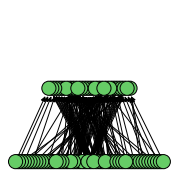

In [55]:
from itertools import product

def resolve_out_to_DAG(out: dict):
    g = nx.DiGraph()

    for qk, d in out['designs'].items():
        if not len(d['assemblies']):
            print("MISSING ASSEMBLY FOR {}".format(d.keys()))
            continue
        reaction_id = d['assemblies'][0]['final_assembly_reaction'][0]

        assembly_reaction = design_out['reactions'][reaction_id]
        
        in_samples = [out['molecules'][i]['__sample__'] for i in assembly_reaction['inputs']]
        out_samples = [out['molecules'][i]['__sample__'] for i in assembly_reaction['outputs']]
        
        for s1, s2 in product(in_samples, out_samples):
            g.add_edge(s1['name'], s2['name'], reaction_id=reaction_id)
    return g
            
with open('design.out.resolved.json', 'r') as f:
    resolved_out = json.load(f)
    
resolved_graph = resolve_out_to_DAG(resolved_out)
print(nx.info(resolved_graph))
plotter = GraphPlotter(resolved_graph)
plotter.topological_sort()
plotter.draw_graph()
plt.show()

### Convert to Terrarium File

*Note: this 

In [57]:
def init_terrarium_design():
    design_file = {
        'TRAIN': {
            'method': 'last',
            'args': [500],
        },
        'MODEL_PATH': 'terrarium.pkl',
        'GOALS': [],
        "GLOBAL_CONSTRAINTS": {
            "EXCLUDE": [
                {
                    "model_class": "OperationType",
                    "query": [
                        {"category": ["Control Blocks", "Library Cloning"]},
                        {"name": "Yeast Mating"},
                        {"name": "Yeast Auxotrophic Plate Mating"},
                        {'name': 'Order Addgene Plasmid'},
                        {'name': 'Assemble Golden Gate'},
                        {'name': 'Anneal Oligos (Beta)'},
                    ]
                }
            ]
        }
    }
    return design_file

In [58]:
# import terrarium

def iter_leaves(g):
    for n in g.nodes:
        if not list(g.successors(n)):
            yield n
            
def iter_roots(g):
    for n in g.nodes:
        if not list(g.predecessors(n)):
            yield n
        

def add_goals(sample_graph, design_file: dict):
    for leaf in iter_leaves(sample_graph):
        tree = nx.dfs_tree(sample_graph.reverse(), leaf).reverse()
        tree = sample_graph.subgraph(list(tree.nodes()))
        tree_leaves = list(iter_leaves(tree))
        assert len(tree_leaves) == 1
        print(leaf)
        new_goal = {}

        goal_sample = session.Sample.find_by_name(leaf)
        new_goal = {
            'PLAN_ID': "Plant TF",
            'SAMPLE': {
                'model_class': 'Sample',
                'query': {
                    'name': goal_sample.name
                }
            },
            'OBJECT_TYPE': {
                'model_class': 'ObjectType',
                'query': {
                    'name': 'Plasmid Glycerol Stock'
                }
            }
        }

        new_goal['EDGES'] = []

        for n1, n2 in tree.edges():
            s1 = session.Sample.find_by_name(n1)
            s2 = session.Sample.find_by_name(n2)
            if s1.sample_type.name == 'Fragment':
                new_goal['EDGES'].append([s1.name, s2.name])
        new_goal['EDGES'].append(['DH5alpha', goal_sample.name])

        design_file['GOALS'].append(new_goal)
    
design_file = init_terrarium_design()
add_goals(resolved_graph, design_file)
with open('dirt.io.json', 'w') as f:
    json.dump(design_file, f)

pMOD6_backbone_Input_node_be_jub1
pMOD8_Backbone_medium_exp_strong_ad_tet
pMOD-HO-KanMX_output_node_4b2_anac102_stable_gfp
pMOD-HO-KanMX_output_node_6b2_ataf1_stable_gfp
pMOD6_backbone_Input_node_be_ataf1
pMOD6_backbone_Input_node_doxy_ataf1
pMOD8_Backbone_medium_exp_strong_ad_zev
pMOD-HO-KanMX_output_node_4b2_ant_stable_gfp
pMOD-HO-KanMX_output_node_2b2_ant_stable_gfp
pMOD8_Backbone_weak_exp_med_ad_tet
pMOD8_Backbone_strong_exp_strong_ad_zev
pMOD-HO-KanMX_output_node_6b2_anac102_stable_gfp
pMOD-HO-KanMX_output_node_6b2_jub1_stable_gfp
pMOD8_Backbone_weak_exp_strong_ad_zev
pMOD6_backbone_Input_node_be_ant
pMOD8_Backbone_strong_exp_strong_ad_tet
pMOD6_backbone_Input_node_doxy_anac102
pMOD-HO-KanMX_output_node_6b2_ant_stable_gfp
pMOD6_backbone_Input_node_doxy_jub1
pMOD8_Backbone_medium_exp_med_ad_zev
pMOD8_Backbone_weak_exp_med_ad_zev
pMOD-HO-KanMX_output_node_2b2_ataf1_stable_gfp
pMOD6_backbone_Input_node_be_anac102
pMOD-HO-KanMX_output_node_4b2_jub1_stable_gfp
pMOD6_backbone_Input_node

In [26]:
p

2020Designs/                pmod6_backbone.gb
config.toml                 pmod8_backbone.gb
credentials.json            pmod-ho-kanmx.gb
DASiOutputToAquarium.ipynb  SelectedInventory.csv
design.out.json             SelectionInventoryFilter.txt
design.out.resolved.json    strong_exp_med_ad_tet.gb
dirt.io.json                SubmitDASi.ipynb
InventoryDataFrame.csv      token.pickle
inventory.df                Untitled2.ipynb
output_plasmids/            Upload_Fragment.csv
ParseBuildRequest.ipynb     Upload_Primer.csv


In [30]:
ls /home/justin/Documents/

'2020-5-4 Setup Netgear Nighthawk in Bridge Mode 112427.md'
'2080TI + Nvidia Cuda Installation for Ubuntu 19.10.md'
 ApplicationsList.txt
 baseball.py
 cheatsheets/
 consent_form_2020_JustinVrana.pdf
 CS507_ProgramSynthesis/
 datasets/
 DeepLearningBook.pdf
 GeometricDL/
 GPUTrainingNotes.md
 IntroToProbabalisticProgramming.pdf
 LinuxIsGarbage.md
 LinuxNotesForProfessionals.pdf
'Machine Learning notes.md'
 NotesForUbuntuInstallation.md
 patient_history_form_JustinVrana2020.pdf
'Pytorch Notes.md'
 recovery/
 remove_old_snaps.sh*
'SSH Setup.md'
 tmp/
 tmptrident/
 TODO.md
 tok
 TqdmForJupyterLab
 wally*
 WOL_Note.md
